<a href="https://colab.research.google.com/github/designerguy13-photonics/SiEPIClab/blob/master/EBeam_anurag_RR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== RR1 (CSV) analysis summary ===
Port: THROUGH
  Estimated FSR      : 0.030 nm
  Q (first resonance): 86519
  ER (first dip)     : 31.90 dB
  First 3 resonances : 1475.008, 1475.032, 1475.112 nm

Port: DROP
  Estimated FSR      : 0.061 nm
  Q (first resonance): 64
  ER (first dip)     : 24.82 dB
  First 3 resonances : 1475.032, 1475.048, 1475.080 nm



KeyError: 'scandata'

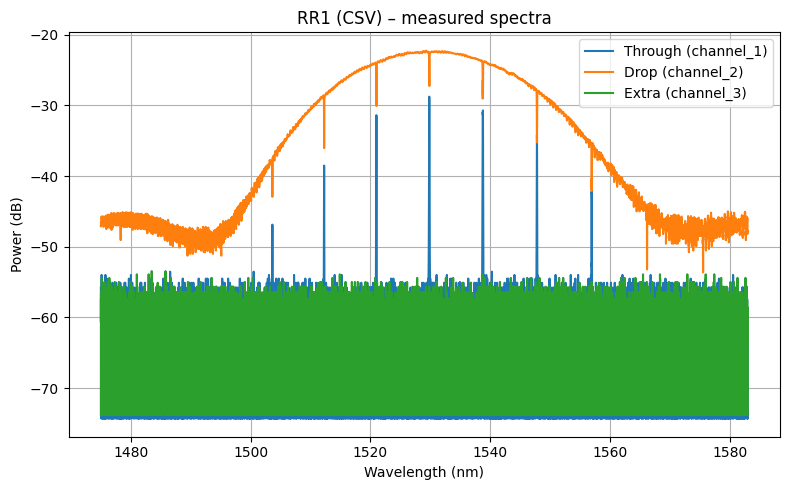

In [5]:
"""
Ring resonator measurement analysis for edX / foundry data.

- Supports CSV files like RR1_measured.csv
  (rows: wavelength, channel_1, channel_2, channel_3)
- Supports .mat "scandata" files from the Python setup
  (fields: scandata.wavelength, scandata.power)

Channel mapping for your chip:
    channel_1 -> Output GC 1 -> THROUGH port
    channel_2 -> Output GC 2 -> DROP port
    channel_3 -> Output GC 3 -> extra / unused
"""

import numpy as np
import matplotlib.pyplot as plt


# ----------------------------------------------------------------------
# 1. LOADING FUNCTIONS
# ----------------------------------------------------------------------

def load_edx_csv(path):
    """
    Load measurement CSV of the form:

        wavelength, λ1, λ2, ...
        channel_1, P1(λ1), P1(λ2), ...
        channel_2, P2(λ1), P2(λ2), ...
        channel_3, P3(λ1), P3(λ2), ...

    Returns:
        lambda_nm : (N,) array of wavelength in nm
        channels  : dict {'channel_1': (N,), 'channel_2': ...} in dB
    """
    with open(path, "r") as f:
        lines = [ln.strip() for ln in f.readlines()]

    # Remove commented lines starting with '#'
    data_lines = [ln for ln in lines if not ln.startswith("#")]
    if len(data_lines) < 4:
        raise ValueError("CSV file does not contain expected wavelength + 3 channels.")

    # wavelength row
    wl_parts = data_lines[0].split(",")
    if not wl_parts[0].lower().startswith("wavelength"):
        raise ValueError("First data line must start with 'wavelength'.")
    lambda_nm = np.array([float(x) for x in wl_parts[1:]])

    channels = {}
    for row in data_lines[1:4]:
        parts = row.split(",")
        label = parts[0].strip()      # "channel_1" etc.
        values = np.array([float(x) for x in parts[1:]])
        channels[label] = values

    return lambda_nm, channels


def load_scandata_mat(path):
    """
    Load Python-style .mat file with scandata struct.

    Expected structure (from foundry instructions):
        lambda = scandata.wavelength';         % 1D array
        power  = scandata.power(:, PORT);      % [Npoints, Nchannels]

    Returns:
        lambda_nm : (N,) wavelength in nm
        channels  : dict {'channel_1': (N,), ...} in dB
    """
    import scipy.io as sio  # local import so script still runs without scipy globally

    mat = sio.loadmat(path, squeeze_me=True)
    scandata = mat["scandata"]

    lambda_m = np.array(scandata["wavelength"]).ravel()
    power = np.array(scandata["power"])

    def to_dB(arr):
        arr = np.array(arr, dtype=float)
        # If already in negative dB, keep; otherwise convert linear -> dB
        if arr.max() <= 0:
            return arr
        return 10 * np.log10(arr)

    channels = {}
    if power.ndim == 1:
        channels["channel_1"] = to_dB(power.ravel())
    else:
        n_ch = power.shape[1]
        for i in range(n_ch):
            channels[f"channel_{i+1}"] = to_dB(power[:, i])

    lambda_nm = lambda_m * 1e9
    return lambda_nm, channels


# ----------------------------------------------------------------------
# 2. ANALYSIS UTILITIES
# ----------------------------------------------------------------------

def normalize_trace(power_dB):
    """
    Normalize a transmission trace in dB so that the maximum = 0 dB.
    """
    return power_dB - np.max(power_dB)


def find_resonances(lambda_nm, power_dB_norm, min_depth_dB=-3):
    """
    Very simple local-minima finder on a normalized (max=0 dB) trace.

    Args:
        lambda_nm      : wavelength array
        power_dB_norm  : normalized power (0 dB max, negative elsewhere)
        min_depth_dB   : only count minima deeper than this (e.g. -3 dB)

    Returns:
        res_lambda_nm : array of resonance wavelengths
        idxs          : indices of those resonances
    """
    l = lambda_nm
    p = power_dB_norm
    idxs = []

    for i in range(1, len(p) - 1):
        if p[i] < p[i - 1] and p[i] < p[i + 1] and p[i] < min_depth_dB:
            idxs.append(i)

    return l[idxs], np.array(idxs, dtype=int)


def estimate_fwhm(lambda_nm, power_dB_norm, idx):
    """
    Estimate FWHM around a particular resonance index.

    - power_dB_norm has max = 0 dB.
    - Resonance dip is at power_dB_norm[idx] (negative).
    - FWHM is the width between the two wavelengths where
      power crosses (dip + 3 dB) on each side.

    Returns:
        fwhm_nm   : approximate FWHM in nm
    """
    p = power_dB_norm
    l = lambda_nm
    dip = p[idx]
    half = dip + 3.0  # 3 dB above the minimum

    # search left
    left = idx
    while left > 0 and p[left] < half:
        left -= 1
    if left == idx:
        return np.nan
    l1, p1 = l[left], p[left]
    l2, p2 = l[left + 1], p[left + 1]
    wl_left = l1 + (half - p1) * (l2 - l1) / (p2 - p1)

    # search right
    right = idx
    while right < len(p) - 1 and p[right] < half:
        right += 1
    if right == idx:
        return np.nan
    r1, rp1 = l[right - 1], p[right - 1]
    r2, rp2 = l[right], p[right]
    wl_right = r1 + (half - rp1) * (r2 - r1) / (rp2 - rp1)

    return wl_right - wl_left


def analyze_ring(lambda_nm, power_dB, label="through"):
    """
    Perform basic analysis of a ring resonator trace:

        - normalization
        - find resonances (local minima)
        - estimate FSR (mean spacing)
        - estimate Q-factor at first resonance
        - estimate extinction ratio at first resonance

    Returns:
        analysis : dict with keys 'resonances_nm', 'FSR_nm',
                   'Q_first', 'ER_first_dB'
    """
    norm = normalize_trace(power_dB)
    res_lam, idxs = find_resonances(lambda_nm, norm, min_depth_dB=-3)

    if len(idxs) < 1:
        print(f"[WARN] No clear resonances found in {label} channel.")
        return {
            "resonances_nm": np.array([]),
            "FSR_nm": np.nan,
            "Q_first": np.nan,
            "ER_first_dB": np.nan,
        }

    # FSR from successive resonances
    if len(res_lam) >= 2:
        fsr = np.mean(np.diff(res_lam))
    else:
        fsr = np.nan

    # first resonance
    i0 = idxs[0]
    lambda0 = lambda_nm[i0]
    dip0 = norm[i0]          # negative value
    fwhm0 = estimate_fwhm(lambda_nm, norm, i0)
    Q0 = lambda0 / fwhm0 if np.isfinite(fwhm0) and fwhm0 > 0 else np.nan
    ER0 = -dip0              # extinction ratio in dB (0 - dip)

    return {
        "resonances_nm": res_lam,
        "FSR_nm": fsr,
        "Q_first": Q0,
        "ER_first_dB": ER0,
    }


# ----------------------------------------------------------------------
# 3. PLOTTING + REPORT-READY SUMMARY
# ----------------------------------------------------------------------

def plot_ring(lambda_nm, channels, device_name="RR1"):
    """
    Plot THROUGH, DROP, EXTRA channels and run analysis.
    'channels' is the dict from the loader.
    """
    # Map channels to physical ports for your chip
    through = channels.get("channel_1", None)  # Output GC1
    drop = channels.get("channel_2", None)     # Output GC2
    extra = channels.get("channel_3", None)    # Output GC3

    plt.figure(figsize=(8, 5))
    if through is not None:
        plt.plot(lambda_nm, through, label="Through (channel_1)")
    if drop is not None:
        plt.plot(lambda_nm, drop, label="Drop (channel_2)")
    if extra is not None:
        plt.plot(lambda_nm, extra, label="Extra (channel_3)")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Power (dB)")
    plt.title(f"{device_name} – measured spectra")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # --- Analysis on through and drop ports ---
    results = {}
    if through is not None:
        results["through"] = analyze_ring(lambda_nm, through, label="through")
    if drop is not None:
        results["drop"] = analyze_ring(lambda_nm, drop, label="drop")

    # Print summary (you can copy this into your report)
    print(f"\n=== {device_name} analysis summary ===")
    for port, res in results.items():
        print(f"Port: {port.upper()}")
        print(f"  Estimated FSR      : {res['FSR_nm']:.3f} nm")
        print(f"  Q (first resonance): {res['Q_first']:.0f}")
        print(f"  ER (first dip)     : {res['ER_first_dB']:.2f} dB")
        if len(res["resonances_nm"]) > 0:
            print("  First 3 resonances :",
                  ", ".join(f"{x:.3f}" for x in res["resonances_nm"][:3]), "nm")
        print()

    return results


# ----------------------------------------------------------------------
# 4. MAIN – RUN FROM HERE
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # ---- Analyze RR1 CSV ----
    # Change this path to where RR1_measured.csv is in your Colab
    csv_file = "/content/17-Nov-2025 09.14.57.csv"
    lambda_nm, channels = load_edx_csv(csv_file)
    res_csv = plot_ring(lambda_nm, channels, device_name="RR1 (CSV)")

    # ---- Analyze RR1 MAT (your given path) ----
    mat_file = "/content/17-Nov-2025 09.14.57.mat"
    lambda_nm_mat, channels_mat = load_scandata_mat(mat_file)
    res_mat = plot_ring(lambda_nm_mat, channels_mat, device_name="RR1 (MAT)")

    plt.show()



=== RR1 analysis summary ===
Port: THROUGH
  Estimated FSR      : 0.030 nm
  Q (first resonance): 149186
  ER (first dip)     : 22.81 dB
  First 3 resonances : 1475.016, 1475.040, 1475.064 nm

Port: DROP
  Estimated FSR      : 0.062 nm
  Q (first resonance): 63
  ER (first dip)     : 25.14 dB
  First 3 resonances : 1475.008, 1475.040, 1475.072 nm

  through_IL_dB: 40.34 dB
  drop_IL_dB: 22.83 dB

=== RR2 analysis summary ===
Port: THROUGH
  Estimated FSR      : 0.030 nm
  Q (first resonance): 149186
  ER (first dip)     : 22.81 dB
  First 3 resonances : 1475.016, 1475.040, 1475.064 nm

Port: DROP
  Estimated FSR      : 0.062 nm
  Q (first resonance): 63
  ER (first dip)     : 25.14 dB
  First 3 resonances : 1475.008, 1475.040, 1475.072 nm

  through_IL_dB: 40.34 dB
  drop_IL_dB: 22.83 dB

=== RR3 analysis summary ===
Port: THROUGH
  Estimated FSR      : 0.030 nm
  Q (first resonance): 95145
  ER (first dip)     : 28.00 dB
  First 3 resonances : 1475.032, 1475.048, 1475.072 nm

Port: D

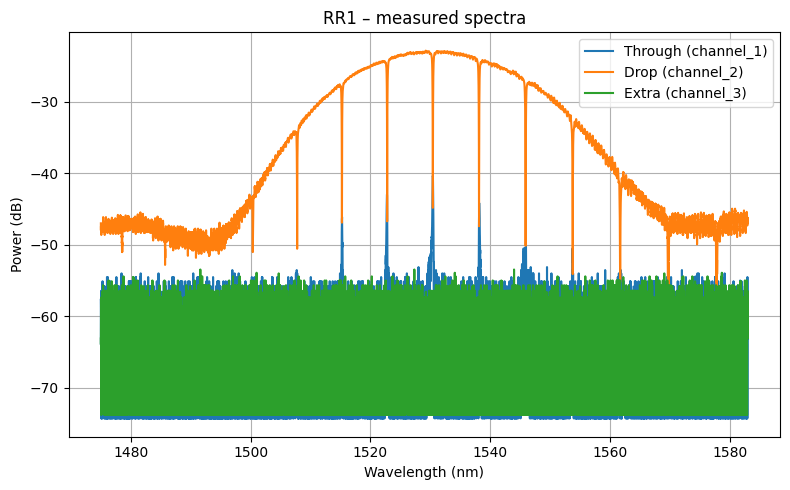

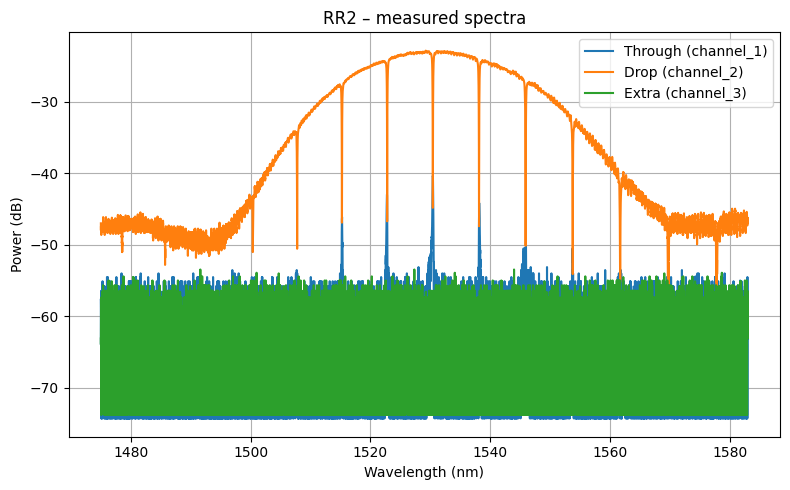

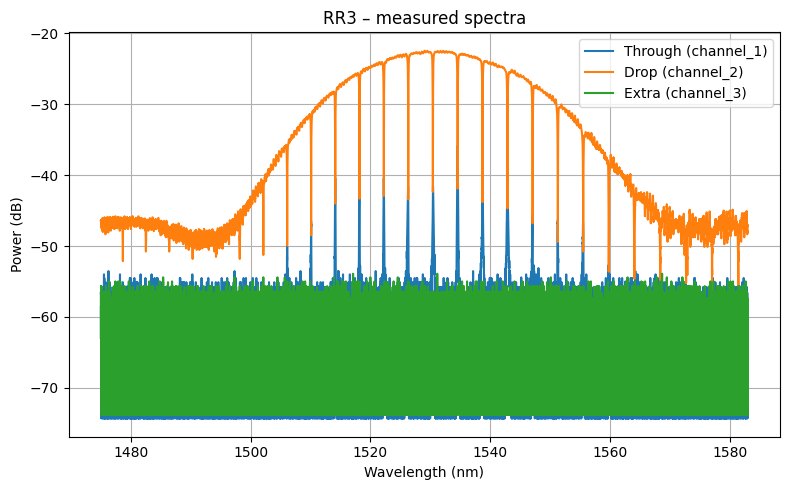

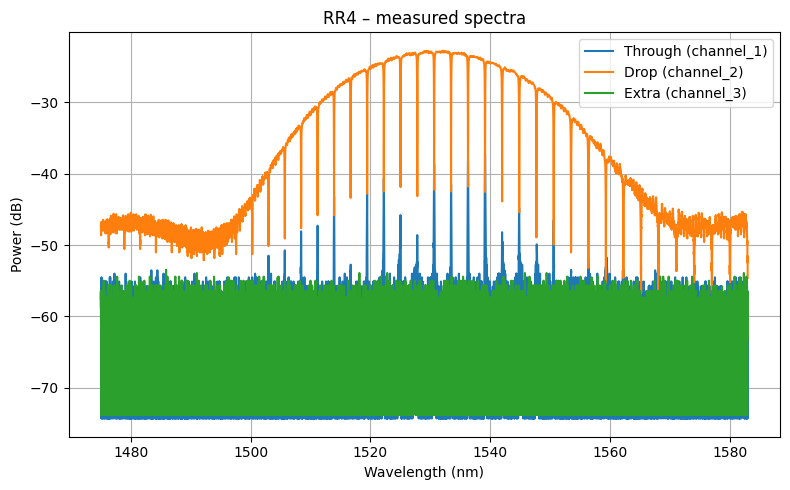

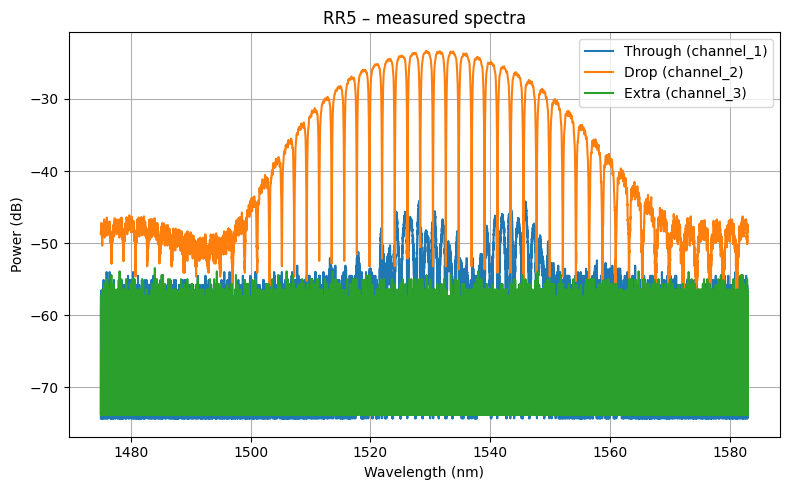

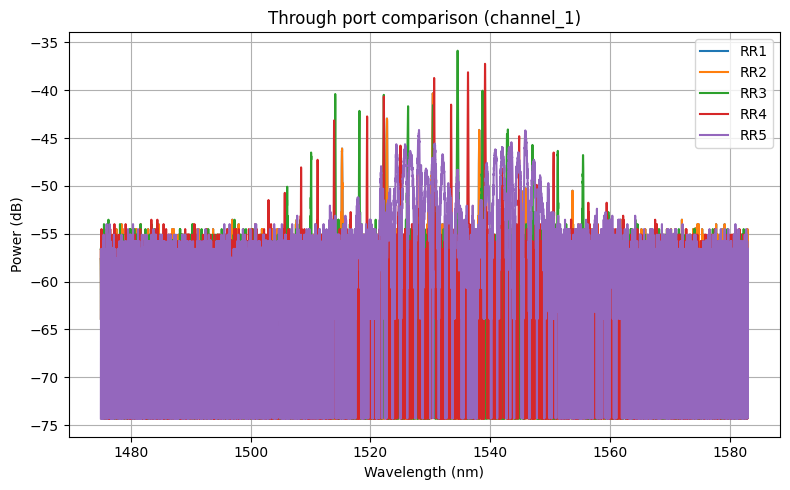

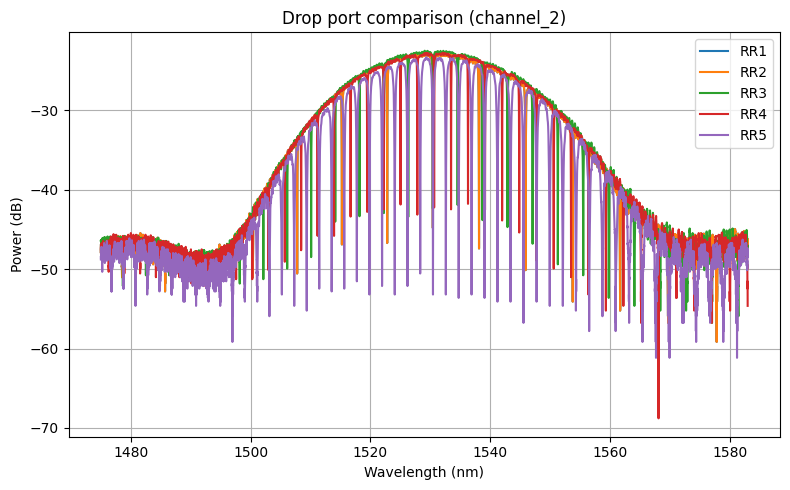

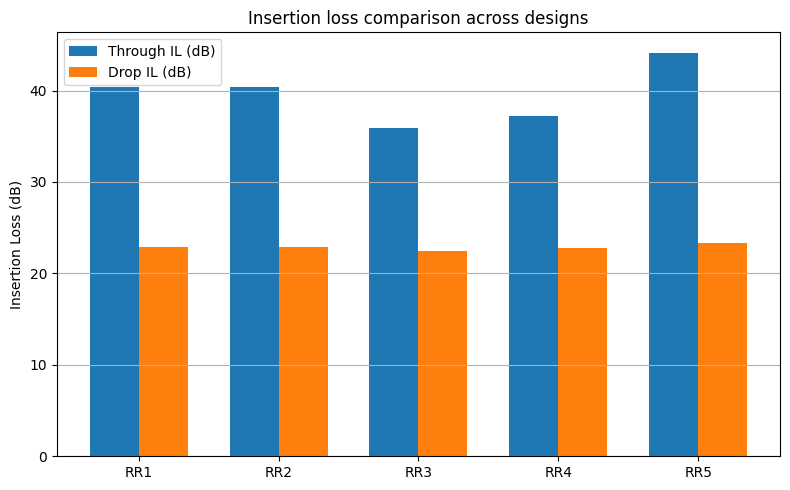


=== Summary table (copy into thesis) ===
Device | Port | FSR (nm) | Q_first | ER_first (dB) | IL (dB)
-------------------------------------------------------------
RR1   | through | 0.030   | 149186   | 22.81       | 40.34
RR1   | drop   | 0.062   | 63   | 25.14       | 22.83
RR2   | through | 0.030   | 149186   | 22.81       | 40.34
RR2   | drop   | 0.062   | 63   | 25.14       | 22.83
RR3   | through | 0.030   | 95145   | 28.00       | 35.88
RR3   | drop   | 0.060   | 59   | 24.05       | 22.48
RR4   | through | 0.030   | 103865   | 26.64       | 37.24
RR4   | drop   | 0.059   | 691   | 25.88       | 22.74
RR5   | through | 0.030   | 34518   | 16.52       | 44.16
RR5   | drop   | 0.061   | 63   | 25.46       | 23.31


In [6]:
"""
Multi-device ring resonator analysis (RR1–RR5)

- Expects files:
    /content/RR1_measured.csv
    /content/RR2_measured.csv
    /content/RR3_measured.csv
    /content/RR4_measured.csv
    /content/RR5_measured.csv

- CSV format (edX-style):
    wavelength, λ1, λ2, ...
    channel_1, P1(λ1), ...
    channel_2, P2(λ1), ...
    channel_3, P3(λ1), ...

- Optional .mat scandata for RR1:
    /content/17-Nov-2025 09.14.57.mat

Channel mapping for your chip:
    channel_1 -> Output GC 1 -> THROUGH port
    channel_2 -> Output GC 2 -> DROP port
    channel_3 -> Output GC 3 -> extra / unused
"""

import os
import numpy as np
import matplotlib.pyplot as plt


# ----------------------------------------------------------------------
# 1. LOADING FUNCTIONS
# ----------------------------------------------------------------------

def load_edx_csv(path):
    """
    Load measurement CSV of the form:

        wavelength, λ1, λ2, ...
        channel_1, P1(λ1), P1(λ2), ...
        channel_2, P2(λ1), P2(λ2), ...
        channel_3, P3(λ1), P3(λ2), ...

    Returns:
        lambda_nm : (N,) array of wavelength in nm
        channels  : dict {'channel_1': (N,), 'channel_2': ...} in dB
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV file not found: {path}")

    with open(path, "r") as f:
        lines = [ln.strip() for ln in f.readlines()]

    # Remove commented lines starting with '#'
    data_lines = [ln for ln in lines if not ln.startswith("#")]
    if len(data_lines) < 4:
        raise ValueError(f"{path} does not contain expected wavelength + 3 channels.")

    # wavelength row
    wl_parts = data_lines[0].split(",")
    if not wl_parts[0].lower().startswith("wavelength"):
        raise ValueError(f"First data line in {path} must start with 'wavelength'.")
    lambda_nm = np.array([float(x) for x in wl_parts[1:]])

    channels = {}
    for row in data_lines[1:4]:
        parts = row.split(",")
        label = parts[0].strip()      # "channel_1" etc.
        values = np.array([float(x) for x in parts[1:]])
        channels[label] = values

    return lambda_nm, channels


def load_scandata_mat(path):
    """
    Load Python-style .mat file with scandata struct (optional).

    Expected structure (from foundry instructions):
        lambda = scandata.wavelength';         % 1D array
        power  = scandata.power(:, PORT);      % [Npoints, Nchannels]

    Returns:
        lambda_nm : (N,) wavelength in nm
        channels  : dict {'channel_1': (N,), ...} in dB
    """
    import scipy.io as sio  # local import

    if not os.path.exists(path):
        raise FileNotFoundError(f"MAT file not found: {path}")

    mat = sio.loadmat(path, squeeze_me=True)
    scandata = mat["scandata"]

    lambda_m = np.array(scandata["wavelength"]).ravel()
    power = np.array(scandata["power"])

    def to_dB(arr):
        arr = np.array(arr, dtype=float)
        # If already in negative dB, keep; otherwise convert linear -> dB
        if arr.max() <= 0:
            return arr
        return 10 * np.log10(arr)

    channels = {}
    if power.ndim == 1:
        channels["channel_1"] = to_dB(power.ravel())
    else:
        n_ch = power.shape[1]
        for i in range(n_ch):
            channels[f"channel_{i+1}"] = to_dB(power[:, i])

    lambda_nm = lambda_m * 1e9
    return lambda_nm, channels


# ----------------------------------------------------------------------
# 2. ANALYSIS UTILITIES
# ----------------------------------------------------------------------

def normalize_trace(power_dB):
    """
    Normalize a transmission trace in dB so that the maximum = 0 dB.
    """
    return power_dB - np.max(power_dB)


def find_resonances(lambda_nm, power_dB_norm, min_depth_dB=-3):
    """
    Simple local-minima finder on a normalized (max=0 dB) trace.

    Args:
        lambda_nm      : wavelength array
        power_dB_norm  : normalized power (0 dB max, negative elsewhere)
        min_depth_dB   : only count minima deeper than this (e.g. -3 dB)

    Returns:
        res_lambda_nm : array of resonance wavelengths
        idxs          : indices of those resonances
    """
    l = lambda_nm
    p = power_dB_norm
    idxs = []

    for i in range(1, len(p) - 1):
        if p[i] < p[i - 1] and p[i] < p[i + 1] and p[i] < min_depth_dB:
            idxs.append(i)

    return l[idxs], np.array(idxs, dtype=int)


def estimate_fwhm(lambda_nm, power_dB_norm, idx):
    """
    Estimate FWHM around a particular resonance index.

    - power_dB_norm has max = 0 dB.
    - Resonance dip is at power_dB_norm[idx] (negative).
    - FWHM is the width between the two wavelengths where
      power crosses (dip + 3 dB) on each side.

    Returns:
        fwhm_nm   : approximate FWHM in nm
    """
    p = power_dB_norm
    l = lambda_nm
    dip = p[idx]
    half = dip + 3.0  # 3 dB above the minimum

    # search left
    left = idx
    while left > 0 and p[left] < half:
        left -= 1
    if left == idx:
        return np.nan
    l1, p1 = l[left], p[left]
    l2, p2 = l[left + 1], p[left + 1]
    wl_left = l1 + (half - p1) * (l2 - l1) / (p2 - p1)

    # search right
    right = idx
    while right < len(p) - 1 and p[right] < half:
        right += 1
    if right == idx:
        return np.nan
    r1, rp1 = l[right - 1], p[right - 1]
    r2, rp2 = l[right], p[right]
    wl_right = r1 + (half - rp1) * (r2 - r1) / (rp2 - rp1)

    return wl_right - wl_left


def analyze_ring(lambda_nm, power_dB, label="through"):
    """
    Perform basic analysis of a ring resonator trace:

        - normalization
        - find resonances (local minima)
        - estimate FSR (mean spacing)
        - estimate Q-factor at first resonance
        - estimate extinction ratio at first resonance

    Returns:
        analysis : dict with keys 'resonances_nm', 'FSR_nm',
                   'Q_first', 'ER_first_dB'
    """
    norm = normalize_trace(power_dB)
    res_lam, idxs = find_resonances(lambda_nm, norm, min_depth_dB=-3)

    if len(idxs) < 1:
        print(f"[WARN] No clear resonances found in {label} channel.")
        return {
            "resonances_nm": np.array([]),
            "FSR_nm": np.nan,
            "Q_first": np.nan,
            "ER_first_dB": np.nan,
        }

    # FSR from successive resonances
    if len(res_lam) >= 2:
        fsr = np.mean(np.diff(res_lam))
    else:
        fsr = np.nan

    # first resonance
    i0 = idxs[0]
    lambda0 = lambda_nm[i0]
    dip0 = norm[i0]          # negative value
    fwhm0 = estimate_fwhm(lambda_nm, norm, i0)
    Q0 = lambda0 / fwhm0 if np.isfinite(fwhm0) and fwhm0 > 0 else np.nan
    ER0 = -dip0              # extinction ratio in dB (0 - dip)

    return {
        "resonances_nm": res_lam,
        "FSR_nm": fsr,
        "Q_first": Q0,
        "ER_first_dB": ER0,
    }


def compute_insertion_loss(power_dB):
    """
    Simple insertion loss estimate:
    IL (dB) = - max(power_dB)

    If max power is -4 dB, IL = 4 dB.
    """
    return -np.nanmax(power_dB)


# ----------------------------------------------------------------------
# 3. PLOTTING + REPORT-READY SUMMARY
# ----------------------------------------------------------------------

def plot_ring(lambda_nm, channels, device_name="RR1"):
    """
    Plot THROUGH, DROP, EXTRA channels and run analysis.
    'channels' is the dict from the loader.
    """
    # Map channels to physical ports for your chip
    through = channels.get("channel_1", None)  # Output GC1
    drop = channels.get("channel_2", None)     # Output GC2
    extra = channels.get("channel_3", None)    # Output GC3

    plt.figure(figsize=(8, 5))
    if through is not None:
        plt.plot(lambda_nm, through, label="Through (channel_1)")
    if drop is not None:
        plt.plot(lambda_nm, drop, label="Drop (channel_2)")
    if extra is not None:
        plt.plot(lambda_nm, extra, label="Extra (channel_3)")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Power (dB)")
    plt.title(f"{device_name} – measured spectra")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # --- Analysis on through and drop ports ---
    results = {}
    if through is not None:
        results["through"] = analyze_ring(lambda_nm, through, label="through")
    if drop is not None:
        results["drop"] = analyze_ring(lambda_nm, drop, label="drop")

    IL = {}
    if through is not None:
        IL["through_IL_dB"] = compute_insertion_loss(through)
    if drop is not None:
        IL["drop_IL_dB"] = compute_insertion_loss(drop)

    # Print summary (for report)
    print(f"\n=== {device_name} analysis summary ===")
    for port, res in results.items():
        print(f"Port: {port.upper()}")
        print(f"  Estimated FSR      : {res['FSR_nm']:.3f} nm")
        print(f"  Q (first resonance): {res['Q_first']:.0f}")
        print(f"  ER (first dip)     : {res['ER_first_dB']:.2f} dB")
        if len(res["resonances_nm"]) > 0:
            print("  First 3 resonances :",
                  ", ".join(f"{x:.3f}" for x in res["resonances_nm"][:3]), "nm")
        print()
    for k, v in IL.items():
        print(f"  {k}: {v:.2f} dB")

    return results, IL


# ----------------------------------------------------------------------
# 4. MAIN – PROCESS RR1–RR5
# ----------------------------------------------------------------------
if __name__ == "__main__":
    DATA_DIR = "/content"   # change if your files are elsewhere

    # List of devices and their CSV paths
    devices = [
        {"name": "RR1", "csv": os.path.join(DATA_DIR, "/content/RR2_measured.csv")},
        {"name": "RR2", "csv": os.path.join(DATA_DIR, "/content/RR2_measured.csv")},
        {"name": "RR3", "csv": os.path.join(DATA_DIR, "/content/RR3_measured.csv")},
        {"name": "RR4", "csv": os.path.join(DATA_DIR, "/content/RR4_measured.csv")},
        {"name": "RR5", "csv": os.path.join(DATA_DIR, "/content/RR5_measyred.csv")},
    ]

    all_results = {}
    all_IL = {}
    all_lambda = {}
    all_channels = {}

    # ---- 4.1 Individual plots + analysis per device ----
    for dev in devices:
        name = dev["name"]
        csv_path = dev["csv"]

        try:
            lambda_nm, channels = load_edx_csv(csv_path)
        except Exception as e:
            print(f"\n[SKIP] {name}: problem loading {csv_path}: {e}")
            continue

        results, IL = plot_ring(lambda_nm, channels, device_name=name)
        all_results[name] = results
        all_IL[name] = IL
        all_lambda[name] = lambda_nm
        all_channels[name] = channels

    # ---- 4.2 Comparison plot: THROUGH port for all designs ----
    plt.figure(figsize=(8, 5))
    for name in all_lambda.keys():
        lambda_nm = all_lambda[name]
        ch = all_channels[name].get("channel_1", None)
        if ch is None:
            continue
        plt.plot(lambda_nm, ch, label=name)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Power (dB)")
    plt.title("Through port comparison (channel_1)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # ---- 4.3 Comparison plot: DROP port for all designs ----
    plt.figure(figsize=(8, 5))
    for name in all_lambda.keys():
        lambda_nm = all_lambda[name]
        ch = all_channels[name].get("channel_2", None)
        if ch is None:
            continue
        plt.plot(lambda_nm, ch, label=name)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Power (dB)")
    plt.title("Drop port comparison (channel_2)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # ---- 4.4 Insertion loss comparison bar plot ----
    dev_names = list(all_IL.keys())
    IL_through = [all_IL[d].get("through_IL_dB", np.nan) for d in dev_names]
    IL_drop = [all_IL[d].get("drop_IL_dB", np.nan) for d in dev_names]

    x = np.arange(len(dev_names))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, IL_through, width, label="Through IL (dB)")
    plt.bar(x + width/2, IL_drop, width, label="Drop IL (dB)")
    plt.xticks(x, dev_names)
    plt.ylabel("Insertion Loss (dB)")
    plt.title("Insertion loss comparison across designs")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()

    # ---- 4.5 Optional: Analyse RR1 MAT as well ----
    # Uncomment if you have the MAT file in /content:
    # try:
    #     mat_file = os.path.join(DATA_DIR, "17-Nov-2025 09.14.57.mat")
    #     lambda_nm_mat, channels_mat = load_scandata_mat(mat_file)
    #     plot_ring(lambda_nm_mat, channels_mat, device_name="RR1 (MAT)")
    # except Exception as e:
    #     print(f"[INFO] Could not process MAT file: {e}")

    plt.show()

    # ---- 4.6 Print compact summary table for thesis/report ----
    print("\n=== Summary table (copy into thesis) ===")
    print("Device | Port | FSR (nm) | Q_first | ER_first (dB) | IL (dB)")
    print("-------------------------------------------------------------")
    for name, res in all_results.items():
        for port in ["through", "drop"]:
            if port in res:
                r = res[port]
                il_key = f"{port}_IL_dB"
                il_val = all_IL[name].get(il_key, np.nan)
                print(f"{name:5s} | {port:6s} | "
                      f"{r['FSR_nm']:.3f}   | "
                      f"{r['Q_first']:.0f}   | "
                      f"{r['ER_first_dB']:.2f}       | "
                      f"{il_val:.2f}")



=== RR1 analysis summary ===
Port: THROUGH
  Estimated FSR      : 0.062 nm
  Q (first resonance): 63
  ER (first dip)     : 25.14 dB
  First 3 resonances : 1475.008, 1475.040, 1475.072 nm

Port: DROP
  Estimated FSR      : 0.030 nm
  Q (first resonance): 40891
  ER (first dip)     : 10.46 dB
  First 3 resonances : 1475.008, 1475.024, 1475.040 nm

  through_IL_dB: 22.83 dB
  drop_IL_dB: 53.45 dB

=== RR2 analysis summary ===
Port: THROUGH
  Estimated FSR      : 0.062 nm
  Q (first resonance): 63
  ER (first dip)     : 25.14 dB
  First 3 resonances : 1475.008, 1475.040, 1475.072 nm

Port: DROP
  Estimated FSR      : 0.030 nm
  Q (first resonance): 40891
  ER (first dip)     : 10.46 dB
  First 3 resonances : 1475.008, 1475.024, 1475.040 nm

  through_IL_dB: 22.83 dB
  drop_IL_dB: 53.45 dB

=== RR3 analysis summary ===
Port: THROUGH
  Estimated FSR      : 0.060 nm
  Q (first resonance): 59
  ER (first dip)     : 24.05 dB
  First 3 resonances : 1475.008, 1475.024, 1475.040 nm

Port: DROP
 

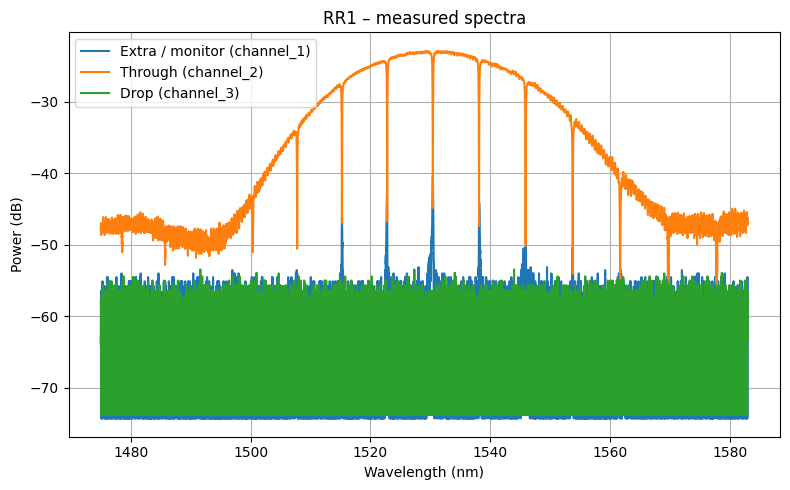

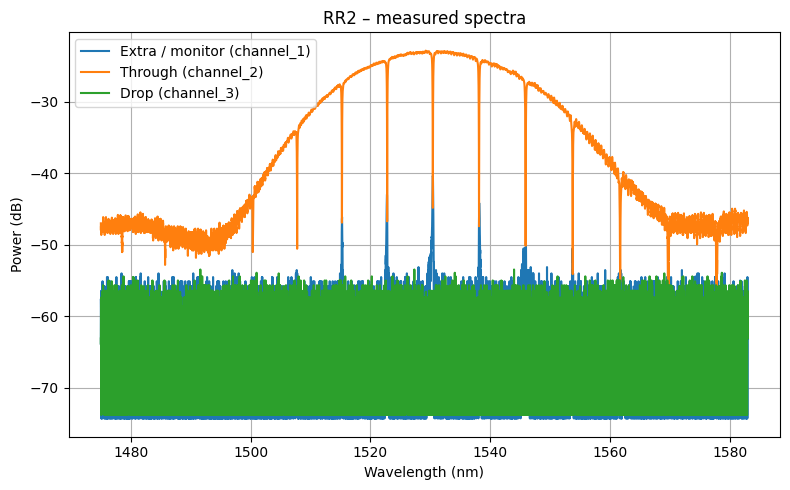

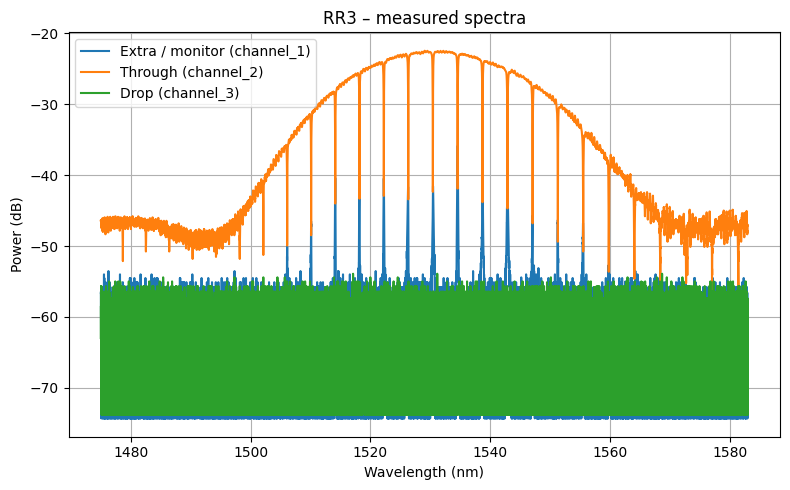

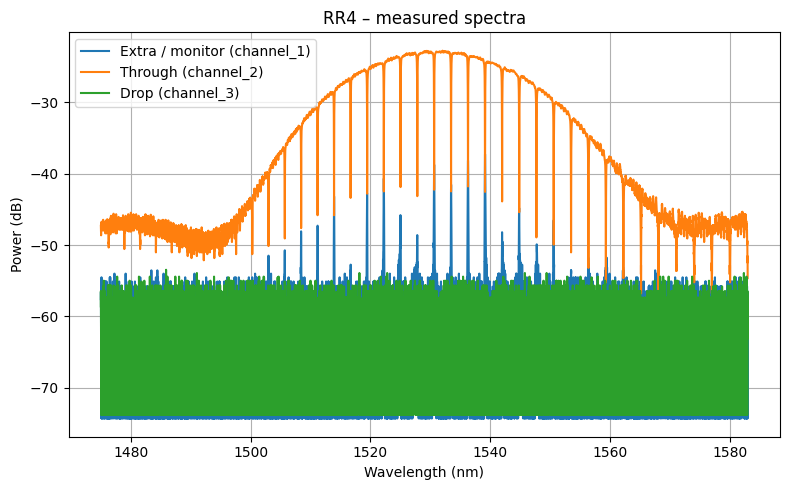

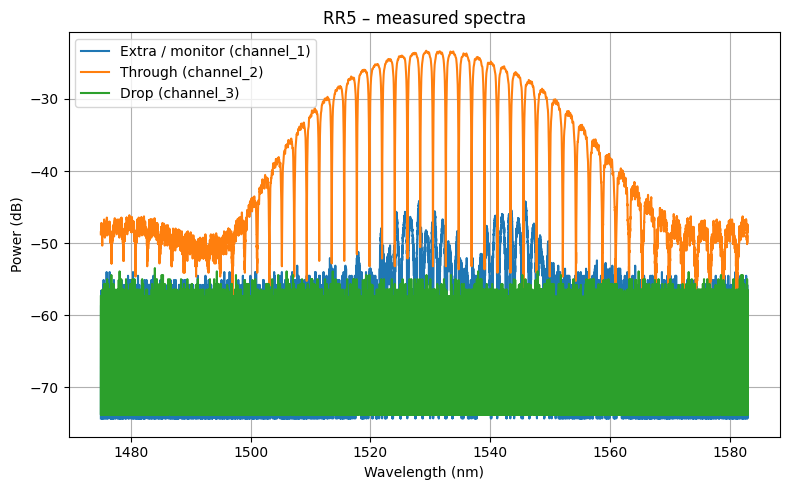

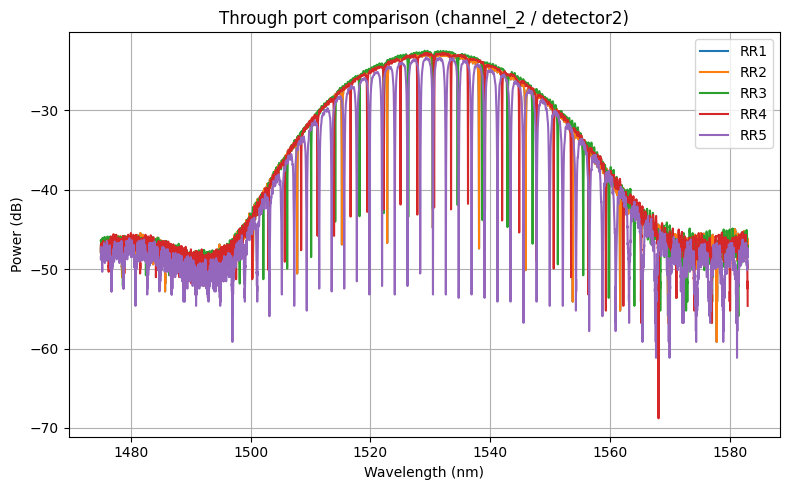

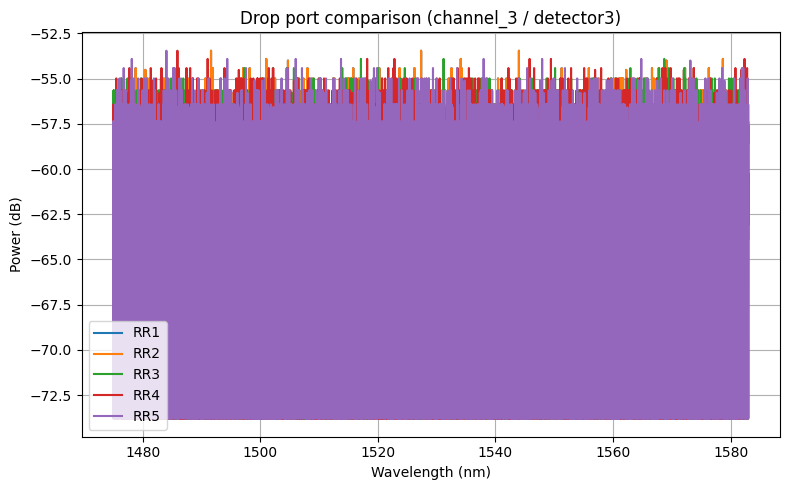

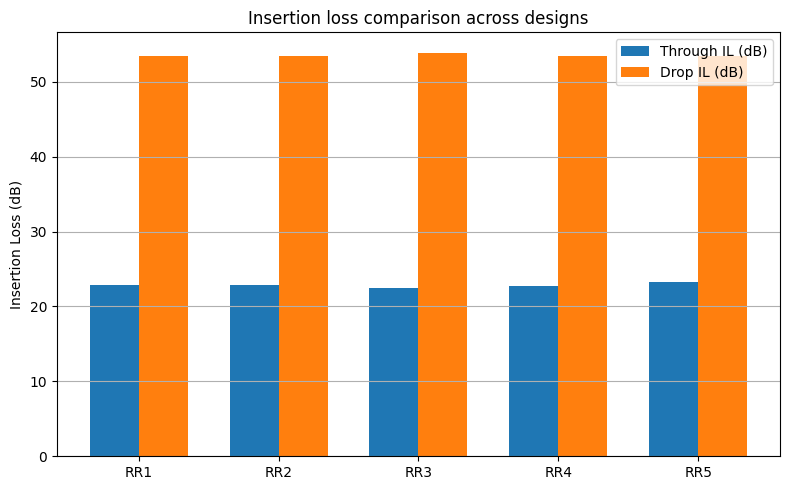


=== Summary table (copy into thesis) ===
Device | Port | FSR (nm) | Q_first | ER_first (dB) | IL (dB)
-------------------------------------------------------------
RR1   | through | 0.062   | 63   | 25.14       | 22.83
RR1   | drop   | 0.030   | 40891   | 10.46       | 53.45
RR2   | through | 0.062   | 63   | 25.14       | 22.83
RR2   | drop   | 0.030   | 40891   | 10.46       | 53.45
RR3   | through | 0.060   | 59   | 24.05       | 22.48
RR3   | drop   | 0.030   | 107750   | 9.20       | 53.91
RR4   | through | 0.059   | 691   | 25.88       | 22.74
RR4   | drop   | 0.030   | 315200   | 20.33       | 53.45
RR5   | through | 0.061   | 63   | 25.46       | 23.31
RR5   | drop   | 0.030   | 455232   | 20.33       | 53.45


In [7]:
"""
Multi-device ring resonator analysis (RR1–RR5)

- Expects files:
    /content/RR1_measured.csv
    /content/RR2_measured.csv
    /content/RR3_measured.csv
    /content/RR4_measured.csv
    /content/RR5_measured.csv

- CSV format (edX-style):
    wavelength, λ1, λ2, ...
    channel_1, P1(λ1), ...
    channel_2, P2(λ1), ...
    channel_3, P3(λ1), ...

- Optional .mat scandata:
    /content/17-Nov-2025 09.14.57.mat

Detector / channel mapping for *your* setup:
    detector1 -> channel_1 -> EXTRA / monitor
    detector2 -> channel_2 -> THROUGH port
    detector3 -> channel_3 -> DROP port
"""

import os
import numpy as np
import matplotlib.pyplot as plt


# ----------------------------------------------------------------------
# 1. LOADING FUNCTIONS
# ----------------------------------------------------------------------

def load_edx_csv(path):
    """
    Load measurement CSV of the form:

        wavelength, λ1, λ2, ...
        channel_1, P1(λ1), P1(λ2), ...
        channel_2, P2(λ1), P2(λ2), ...
        channel_3, P3(λ1), P3(λ2), ...

    Returns:
        lambda_nm : (N,) array of wavelength in nm
        channels  : dict {'channel_1': (N,), 'channel_2': ...} in dB
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV file not found: {path}")

    with open(path, "r") as f:
        lines = [ln.strip() for ln in f.readlines()]

    # Remove commented lines starting with '#'
    data_lines = [ln for ln in lines if not ln.startswith("#")]
    if len(data_lines) < 4:
        raise ValueError(f"{path} does not contain expected wavelength + 3 channels.")

    # wavelength row
    wl_parts = data_lines[0].split(",")
    if not wl_parts[0].lower().startswith("wavelength"):
        raise ValueError(f"First data line in {path} must start with 'wavelength'.")
    lambda_nm = np.array([float(x) for x in wl_parts[1:]])

    channels = {}
    for row in data_lines[1:4]:
        parts = row.split(",")
        label = parts[0].strip()      # "channel_1" etc.
        values = np.array([float(x) for x in parts[1:]])
        channels[label] = values

    return lambda_nm, channels


def load_scandata_mat(path):
    """
    Load Python-style .mat file with scandata struct (optional).

    Expected structure:
        scandata.wavelength   % [N]
        scandata.power        % [N, Nchannels]

    Returns:
        lambda_nm : (N,) wavelength in nm
        channels  : dict {'channel_1': (N,), ...} in dB
    """
    import scipy.io as sio  # local import

    if not os.path.exists(path):
        raise FileNotFoundError(f"MAT file not found: {path}")

    mat = sio.loadmat(path, squeeze_me=True)
    scandata = mat["scandata"]

    lambda_m = np.array(scandata["wavelength"]).ravel()
    power = np.array(scandata["power"])

    def to_dB(arr):
        arr = np.array(arr, dtype=float)
        # If already in negative dB, keep; otherwise convert linear -> dB
        if arr.max() <= 0:
            return arr
        return 10 * np.log10(arr)

    channels = {}
    if power.ndim == 1:
        channels["channel_1"] = to_dB(power.ravel())
    else:
        n_ch = power.shape[1]
        for i in range(n_ch):
            channels[f"channel_{i+1}"] = to_dB(power[:, i])

    lambda_nm = lambda_m * 1e9
    return lambda_nm, channels


# ----------------------------------------------------------------------
# 2. ANALYSIS UTILITIES
# ----------------------------------------------------------------------

def normalize_trace(power_dB):
    """Normalize a transmission trace in dB so that the maximum = 0 dB."""
    return power_dB - np.max(power_dB)


def find_resonances(lambda_nm, power_dB_norm, min_depth_dB=-3):
    """
    Simple local-minima finder on a normalized (max=0 dB) trace.

    Args:
        lambda_nm      : wavelength array
        power_dB_norm  : normalized power (0 dB max, negative elsewhere)
        min_depth_dB   : only count minima deeper than this (e.g. -3 dB)

    Returns:
        res_lambda_nm : array of resonance wavelengths
        idxs          : indices of those resonances
    """
    l = lambda_nm
    p = power_dB_norm
    idxs = []

    for i in range(1, len(p) - 1):
        if p[i] < p[i - 1] and p[i] < p[i + 1] and p[i] < min_depth_dB:
            idxs.append(i)

    return l[idxs], np.array(idxs, dtype=int)


def estimate_fwhm(lambda_nm, power_dB_norm, idx):
    """
    Estimate FWHM around a particular resonance index.

    - power_dB_norm has max = 0 dB.
    - Resonance dip is at power_dB_norm[idx] (negative).
    - FWHM is the width between the two wavelengths where
      power crosses (dip + 3 dB) on each side.

    Returns:
        fwhm_nm   : approximate FWHM in nm
    """
    p = power_dB_norm
    l = lambda_nm
    dip = p[idx]
    half = dip + 3.0  # 3 dB above the minimum

    # search left
    left = idx
    while left > 0 and p[left] < half:
        left -= 1
    if left == idx:
        return np.nan
    l1, p1 = l[left], p[left]
    l2, p2 = l[left + 1], p[left + 1]
    wl_left = l1 + (half - p1) * (l2 - l1) / (p2 - p1)

    # search right
    right = idx
    while right < len(p) - 1 and p[right] < half:
        right += 1
    if right == idx:
        return np.nan
    r1, rp1 = l[right - 1], p[right - 1]
    r2, rp2 = l[right], p[right]
    wl_right = r1 + (half - rp1) * (r2 - r1) / (rp2 - rp1)

    return wl_right - wl_left


def analyze_ring(lambda_nm, power_dB, label="through"):
    """
    Perform basic analysis of a ring resonator trace:

        - normalization
        - find resonances (local minima)
        - estimate FSR (mean spacing)
        - estimate Q-factor at first resonance
        - estimate extinction ratio at first resonance

    Returns:
        analysis : dict with keys 'resonances_nm', 'FSR_nm',
                   'Q_first', 'ER_first_dB'
    """
    norm = normalize_trace(power_dB)
    res_lam, idxs = find_resonances(lambda_nm, norm, min_depth_dB=-3)

    if len(idxs) < 1:
        print(f"[WARN] No clear resonances found in {label} channel.")
        return {
            "resonances_nm": np.array([]),
            "FSR_nm": np.nan,
            "Q_first": np.nan,
            "ER_first_dB": np.nan,
        }

    # FSR from successive resonances
    if len(res_lam) >= 2:
        fsr = np.mean(np.diff(res_lam))
    else:
        fsr = np.nan

    # first resonance
    i0 = idxs[0]
    lambda0 = lambda_nm[i0]
    dip0 = norm[i0]          # negative value
    fwhm0 = estimate_fwhm(lambda_nm, norm, i0)
    Q0 = lambda0 / fwhm0 if np.isfinite(fwhm0) and fwhm0 > 0 else np.nan
    ER0 = -dip0              # extinction ratio in dB (0 - dip)

    return {
        "resonances_nm": res_lam,
        "FSR_nm": fsr,
        "Q_first": Q0,
        "ER_first_dB": ER0,
    }


def compute_insertion_loss(power_dB):
    """
    Simple insertion loss estimate:
    IL (dB) = - max(power_dB)

    If max power is -4 dB, IL = 4 dB.
    """
    return -np.nanmax(power_dB)


# ----------------------------------------------------------------------
# 3. PLOTTING + REPORT-READY SUMMARY
# ----------------------------------------------------------------------

def plot_ring(lambda_nm, channels, device_name="RR1"):
    """
    Plot EXTRA, THROUGH, DROP channels and run analysis.

    With your mapping:
        channel_1 -> extra
        channel_2 -> through
        channel_3 -> drop
    """
    extra   = channels.get("channel_1", None)  # detector1
    through = channels.get("channel_2", None)  # detector2 (THROUGH)
    drop    = channels.get("channel_3", None)  # detector3 (DROP)

    plt.figure(figsize=(8, 5))
    if extra is not None:
        plt.plot(lambda_nm, extra, label="Extra / monitor (channel_1)")
    if through is not None:
        plt.plot(lambda_nm, through, label="Through (channel_2)")
    if drop is not None:
        plt.plot(lambda_nm, drop, label="Drop (channel_3)")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Power (dB)")
    plt.title(f"{device_name} – measured spectra")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # --- Analysis on through and drop ports only ---
    results = {}
    if through is not None:
        results["through"] = analyze_ring(lambda_nm, through, label="through")
    if drop is not None:
        results["drop"] = analyze_ring(lambda_nm, drop, label="drop")

    IL = {}
    if through is not None:
        IL["through_IL_dB"] = compute_insertion_loss(through)
    if drop is not None:
        IL["drop_IL_dB"] = compute_insertion_loss(drop)

    # Print summary (for report)
    print(f"\n=== {device_name} analysis summary ===")
    for port, res in results.items():
        print(f"Port: {port.upper()}")
        print(f"  Estimated FSR      : {res['FSR_nm']:.3f} nm")
        print(f"  Q (first resonance): {res['Q_first']:.0f}")
        print(f"  ER (first dip)     : {res['ER_first_dB']:.2f} dB")
        if len(res["resonances_nm"]) > 0:
            print("  First 3 resonances :",
                  ", ".join(f"{x:.3f}" for x in res["resonances_nm"][:3]), "nm")
        print()
    for k, v in IL.items():
        print(f"  {k}: {v:.2f} dB")

    return results, IL


# ----------------------------------------------------------------------
# 4. MAIN – PROCESS RR1–RR5
# ----------------------------------------------------------------------
if __name__ == "__main__":
    DATA_DIR = "/content"   # change if your files are elsewhere

    devices = [
        {"name": "RR1", "csv": os.path.join(DATA_DIR, "/content/RR2_measured.csv")},
        {"name": "RR2", "csv": os.path.join(DATA_DIR, "/content/RR2_measured.csv")},
        {"name": "RR3", "csv": os.path.join(DATA_DIR, "/content/RR3_measured.csv")},
        {"name": "RR4", "csv": os.path.join(DATA_DIR, "/content/RR4_measured.csv")},
        {"name": "RR5", "csv": os.path.join(DATA_DIR, "/content/RR5_measyred.csv")},
    ]

    all_results = {}
    all_IL = {}
    all_lambda = {}
    all_channels = {}

    # ---- 4.1 Individual plots + analysis per device ----
    for dev in devices:
        name = dev["name"]
        csv_path = dev["csv"]

        try:
            lambda_nm, channels = load_edx_csv(csv_path)
        except Exception as e:
            print(f"\n[SKIP] {name}: problem loading {csv_path}: {e}")
            continue

        results, IL = plot_ring(lambda_nm, channels, device_name=name)
        all_results[name] = results
        all_IL[name] = IL
        all_lambda[name] = lambda_nm
        all_channels[name] = channels

    # ---- 4.2 Comparison plot: THROUGH port (channel_2) for all designs ----
    plt.figure(figsize=(8, 5))
    for name in all_lambda.keys():
        lambda_nm = all_lambda[name]
        ch = all_channels[name].get("channel_2", None)  # THROUGH
        if ch is None:
            continue
        plt.plot(lambda_nm, ch, label=name)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Power (dB)")
    plt.title("Through port comparison (channel_2 / detector2)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # ---- 4.3 Comparison plot: DROP port (channel_3) for all designs ----
    plt.figure(figsize=(8, 5))
    for name in all_lambda.keys():
        lambda_nm = all_lambda[name]
        ch = all_channels[name].get("channel_3", None)  # DROP
        if ch is None:
            continue
        plt.plot(lambda_nm, ch, label=name)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Power (dB)")
    plt.title("Drop port comparison (channel_3 / detector3)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # ---- 4.4 Insertion loss comparison bar plot ----
    dev_names = list(all_IL.keys())
    IL_through = [all_IL[d].get("through_IL_dB", np.nan) for d in dev_names]
    IL_drop = [all_IL[d].get("drop_IL_dB", np.nan) for d in dev_names]

    x = np.arange(len(dev_names))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, IL_through, width, label="Through IL (dB)")
    plt.bar(x + width/2, IL_drop, width, label="Drop IL (dB)")
    plt.xticks(x, dev_names)
    plt.ylabel("Insertion Loss (dB)")
    plt.title("Insertion loss comparison across designs")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()

    # ---- 4.5 Optional: Analyse RR1 MAT as well ----
    # Uncomment if you have the MAT file in /content:
    # try:
    #     mat_file = os.path.join(DATA_DIR, "17-Nov-2025 09.14.57.mat")
    #     lambda_nm_mat, channels_mat = load_scandata_mat(mat_file)
    #     plot_ring(lambda_nm_mat, channels_mat, device_name="RR1 (MAT)")
    # except Exception as e:
    #     print(f"[INFO] Could not process MAT file: {e}")

    plt.show()

    # ---- 4.6 Print compact summary table for thesis/report ----
    print("\n=== Summary table (copy into thesis) ===")
    print("Device | Port | FSR (nm) | Q_first | ER_first (dB) | IL (dB)")
    print("-------------------------------------------------------------")
    for name, res in all_results.items():
        for port in ["through", "drop"]:
            if port in res:
                r = res[port]
                il_key = f"{port}_IL_dB"
                il_val = all_IL[name].get(il_key, np.nan)
                print(f"{name:5s} | {port:6s} | "
                      f"{r['FSR_nm']:.3f}   | "
                      f"{r['Q_first']:.0f}   | "
                      f"{r['ER_first_dB']:.2f}       | "
                      f"{il_val:.2f}")
